In [1]:
import keras

keras.__version__

Using TensorFlow backend.


'2.2.4'

## 7.3 모델의 성능을 최대로 끌어올리기

- 머신러닝 경연 대회에서 우승하는 모델을 만들기 위해 꼭 알아야 할 기법들을 알아보도록 하자.

### 7.3.1 고급 구조 패턴

#### 1) 배치 정규화 (Batch Normalization)

- [[링크](http://excelsior-cjh.tistory.com/178?category=940400)] 참고

- **정규화**(normalization)는 머신러닝 모델에 주입되는 샘플들을 균일하게 만드는 방법이다.

- 모델이 학습하고 새로운 데이터에 잘 일반화되도록 도와준다.

- 데이터에서 평균($\mu$)을 빼서 데이터를 원점에 맞추고 표준편차($\sigma$)로 나누어 데이터의 분산을 1로 만들어 준다.

$$
\text{N} \left( \mu, \sigma^{2} \right) \rightarrow \text{N} \left( 0, 1 \right)
$$

- 데이터 정규화는 네트워크에서 일어나는 모든 변환 후에도 고려되어야 한다.

    - `Dense`나 `Conv2D` 층에 들어가는 데이터의 평균이 0이고 분산이 1이더라도 출력되는 데이터가 동일한 분포를 가질 것이라고 기대하기 어렵다.

- **배치 정규화**(batch normalization)는 2015년 Sergety Ioffe와 Christian Szegedy가 제안한 층(layer)의 한 종류다. → [[링크](https://arxiv.org/pdf/1502.03167.pdf)] 참고

- 훈련하는 동안 평균과 분산이 바뀌더라도 이에 적응(학습)하여 데이터를 정규화한다.

- 훈련 과정에서 사용된 배치 데이터의 평균과 분산에 대한 지수 이동 평균(exponential moving average)을 내부에 유지한다.

- 배치 정규화의 주요 효과는 입력과 출력의 분포를 유지하도록 하여 그래디언트의 전파를 도와주는 것이다.

- `BatchNormalization` 층은 일반적으로 합성곱이나 완전 연결 층 다음에 사용한다.


- `BatchNormalization(axis=-1)` 클래스에는 정규화할 특성 축을 지정하는 `axis` 매개변수가 있다.

    - 이 매개변수의 기본값은 입력 텐서의 마지막 축을 나타내는 `-1`이다.
    
    - `Conv2D`에서 `data_format`을 `"channels_last"`로 하여 `Dense, Conv1D, RNN, Conv2D` 층을 사용할 때 맞는 값이다.

![](./images/bn02.png)

#### 케라스에서 배치정규화 사용 예제

In [17]:
from keras import layers, models
from keras import backend as K

K.clear_session()

model = models.Sequential(
    [layers.Dense(128, input_shape=(784,)),
     layers.BatchNormalization(),
     layers.Activation('relu')]
)

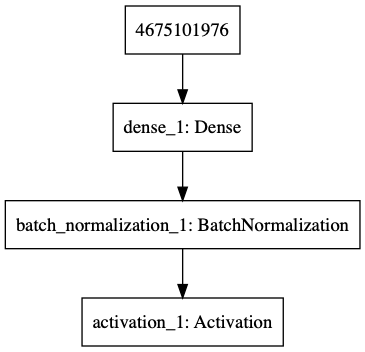

In [18]:
from IPython.display import Image
from keras.utils import plot_model

plot_model(model, to_file='./plot-model/bn.png')
Image(filename='./plot-model/bn.png')

#### 2) 깊이별 분리 합성곱 (Depthwise Separable Convolution)


- [깊이별 분리 합성곱](https://keras.io/layers/convolutional/)(`SeparableConv2D`)은 `Conv2D`를 대체하면서 더 가볍고(훈련할 가중치가 더 적고) 더 빠른 합성곱 층이다.


- `SeparableConv2D`의 합성곱 연산은 다음과 같다.

    1. `SeparableConv2D` 층은 입력 **채널(깊이, depth)별**로 따로따로 공간 방향의 합성곱(spatial convolution)을 수행한다. 

    2. 그 다음 **점별 합성곱**(pointwise conv, $1 \times 1$ 합성곱)을 통해 출력 채널(깊이)를 합친다.
        - 이것은 공간 특성의 학습과 채널 방향 특성의 학습을 분리하는 효과를 낸다.
        
        - 입력에서 공간상의 위치는 상관관계가 크지만 채널별로는 매우 독립적이라고 가정한다면 타당하다.
        

- 이 방법은 모델 파라미터와 연산의 수를 크게 줄여 주기 때문에 작고 더 빠른 모델을 만든다.


- 합성곱을 통해 더 효율적으로 표현을 학습하기 때문에 적은 데이터로도 더 좋은 표현을 학습하고, 성능이 좋은 모델을 만든다.

    - 제한된 데이터로 작은 모델을 처음부터 훈련시킬 때 유용하다.
    
    
- 다음의 예제는 작은 데이터셋에서 이미지 분류 문제(소프트맥스 분류)를 위한 가벼운 깊이별 분리 컨브넷을 만드는 예제이다.

![](./images/depthwise02.png)

#### 케라스를 이용한 `SeparableConv2D` 구현하기

In [1]:
# Minist Dataset load
from keras.datasets import mnist

(train_x, train_y), (test_x, test_y) = mnist.load_data()
train_x = train_x.reshape([-1, 28, 28, 1]) / 255.
test_x = test_x.reshape([-1, 28, 28, 1]) / 255.

print('train_x.shape :', train_x.shape)
print('test_x.shape :', test_x.shape)

Using TensorFlow backend.


train_x.shape : (60000, 28, 28, 1)
test_x.shape : (10000, 28, 28, 1)


In [2]:
from keras import layers
from keras import backend as K
from keras.models import Sequential


K.clear_session()

#################
# layers params #
#################
height, width, channels = (28, 28, 1)
num_classes = 10

# Model
model = Sequential()
model.add(layers.SeparableConv2D(32, 3, padding='same', activation='relu', 
                                 input_shape=(height, width, channels,)))
model.add(layers.MaxPooling2D(2))

model.add(layers.SeparableConv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(2))

model.add(layers.SeparableConv2D(128, 3, padding='same', activation='relu'))
model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

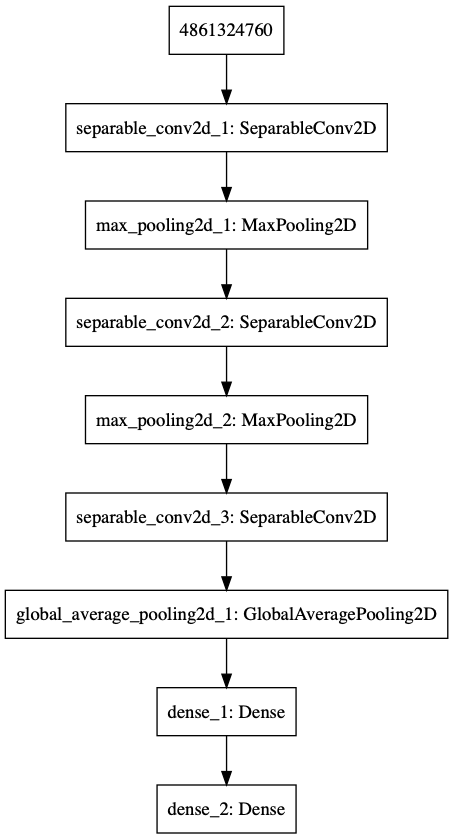

In [3]:
from IPython.display import Image
from keras.utils import plot_model

plot_model(model, to_file='./plot-model/depthwise.png')
Image(filename='./plot-model/depthwise.png')

In [5]:
from keras.optimizers import Adam

model.compile(optimizer=Adam(lr=0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

model.fit(train_x, train_y,
          batch_size=64,
          epochs=5,
          validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 44s 921us/step - loss: 0.8487 - acc: 0.7017 - val_loss: 0.1883 - val_acc: 0.9461
Epoch 2/5
48000/48000 [==============================] - 41s 859us/step - loss: 0.2009 - acc: 0.9379 - val_loss: 0.1285 - val_acc: 0.9620
Epoch 3/5
48000/48000 [==============================] - 40s 834us/step - loss: 0.1379 - acc: 0.9567 - val_loss: 0.1265 - val_acc: 0.9625
Epoch 4/5
48000/48000 [==============================] - 37s 780us/step - loss: 0.1065 - acc: 0.9668 - val_loss: 0.1767 - val_acc: 0.9451
Epoch 5/5
48000/48000 [==============================] - 38s 784us/step - loss: 0.0925 - acc: 0.9714 - val_loss: 0.1021 - val_acc: 0.9713


### 7.3.2 하이퍼파라미터 최적화

- 최적의 하이퍼파라미터 값을 찾기위해 옵션을 수정하고 모델을 반복적으로 다시 훈련하여 값을 개선해 나가야 한다.

- 하이퍼파라미터의 가능한 결정공간을 자동적, 조직적, 규칙적 방법으로 탐색해야 한다.


- 전형적인 하이퍼파라미터 최적화 과정은 다음과 같다.

    1. 일련의 하이퍼파라미터를 (자동으로)선택한다.
    2. 선택된 하이퍼파라미터로 모델을 만든다.
    3. 훈련 데이터에 학습하고 검증 데이터에서 최종 성능을 측정한다.
    4. 다음으로 시도할 하이퍼파라미터를 (자동으로) 선택한다.
    5. 이 과정을 반복한다.
    6. 마지막으로 테스트 데이터에서 성능을 측정한다.
    
    
- 하이퍼파라미터를 선택하는 알고리즘으로는 베이지안 최적화(bayesian optimization), 유전 알고리즘(genetic algorithms), 간단한 랜덤 탐색(random search) 등이 있다.

- 이 분야가 아직 초창기(?)이기 때문에 모델 최적화에 사용할 도구가 매우 적다. 

- 가장 단순하지만 종종 랜덤 탐색이 제일 좋은 방법일 때가 많다.

- 케라스에서 [`keras.wrappers.scikit_learn`](https://keras.io/scikit-learn-api/) 모듈 아래에 있는 `KerasClassifier`와 `KerasRegressor` 클래스를 사용하면 Scikit-Learn의 `RandomizedSearchCV`를 사용하여 랜덤한 하이퍼파라미터 탐색을 수행할 수 있다.

- [Hyperas](https://github.com/maxpumperla/hyperas)는 `Hyperopt`라는 하이퍼파라미터 탐색 모듈과 케라스를 연동하여 케라스 모델에 사용할 수 있다.

- 전체적으로 보았을 때 하이퍼파라미터 최적화는 어느 작업에서 최고의 모델을 얻거나 머신러닝 경연 대회에서 우승하기 위한 강력한 도구이다.

#### `KerasClassifier`를 